# Validação do Modelo

***

## Índice

1. [Métricas](#Importando-bibliotecas)
2. [Validação cruzada](#Validação-cruzada)

## Métricas

Existem várias formas de avaliar um modelo de aprendizagem, dependendo da tarefa que o modelo irá realizar.

Classificação:
- [ROC](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html): Mede o trade-off entre a taxa de falsos positivos e a taxa de verdadeiros positivos. Quanto maior a área abaixo da curva, melhor o classificador.
- [Acurácia](https://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score): Calcula a razão das predições corretas.
- [Precisão](https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics): Mede a capacidade do classificador de não classificar uma instância positiva como negativa.
- [Revocação](https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics) (recall): Mede a capacidade do classificador de encontrar todas as instâncias positivas.
- [Score F1](https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics): É a média harmônica entre precisão e revocação. Caso você não tenha um objetivo concreto que dê prioridade a precisão ou revocação, F1 é uma boa forma de avaliação.

Regressão:
- [MSE](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error): Mede o erro quadrático médio entre as previsões do classificador e o dataset.



In [164]:
import numpy as np

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier


[[12  2]
 [ 0 25]]


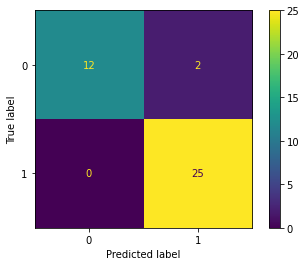

In [179]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

X, y = load_wine(return_X_y=True, as_frame=True)

class_a = 0
class_b = 1

class_0_instances = (y == class_a)
class_1_instances = (y == class_b)
filtered_y = y[class_0_instances | class_1_instances]
filtered_X = X[class_0_instances | class_1_instances]

# dividir classificador em treino e teste
X_train, X_test, y_train, y_test = train_test_split(filtered_X, filtered_y, test_size=0.3, random_state=199)

model = DecisionTreeClassifier(random_state=199)
model.fit(X_train, y_train)

# a função confusion matrix lhe retorna uma matriz com a contagem de como cada uma das classes está sendo classificada corretamente ou erroneamente
predicted_y = model.predict(X_test)
label = [0, 1]
print(confusion_matrix(y_test, predicted_y, labels=[0, 1])) #labels define como será a ordem das classes na matriz
plot_confusion_matrix(model, X_test, y_test, labels=[0, 1])

In [180]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predicted_y))

              precision    recall  f1-score   support

           0       1.00      0.86      0.92        14
           1       0.93      1.00      0.96        25

    accuracy                           0.95        39
   macro avg       0.96      0.93      0.94        39
weighted avg       0.95      0.95      0.95        39



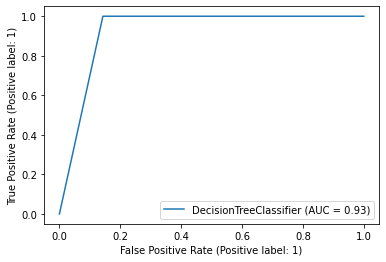

In [181]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(model, X_test, y_test)

## Validação cruzada

**Utilizar qualquer fração do dataset de treino durante a avaliação de um modelo é um erro metodológico**

O objetivo desse tópico é como garantir que a fração do dataset usada no teste do modelo jamais deve ter sido vista pelo modelo, não deve ter sido usada para realizar qualquer processo de otimização no modelo, ou qualquer característica ou distribuição dos dados ter sido usada durante a concepção do modelo.

Dito isso, vamos entender como pensar numa metodologia para avaliação dos nossos modelos.


### Hold-out

Uma pequena fração do dataset é separada para teste e outra para treino. A fração de treino pode ser dividida subsequentemente em quaisquer outros subconjuntos, o importante é garantir que o dataset de teste não é utilizado durante treino, otimização ou concepção do modelo.

In [140]:
# dividir classificador em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=199)

model = DecisionTreeClassifier(random_state=199)
model.fit(X_train, y_train)

accuracy = model.score(X_test, y_test)
print(accuracy)

0.9629629629629629


Um simples hold-out depende bastante da seleção inicial.

In [60]:
def test_model(X_train, X_test, y_train, y_test, model_class=DecisionTreeClassifier):
    model = model_class(random_state=199)
    model.fit(X_train, y_train)

    accuracy = model.score(X_test, y_test)
    return accuracy
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=199)
print(test_model(X_train, X_test, y_train, y_test))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=200)
print(test_model(X_train, X_test, y_train, y_test))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=201)
print(test_model(X_train, X_test, y_train, y_test))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=202)
print(test_model(X_train, X_test, y_train, y_test))


0.9629629629629629
0.9074074074074074
0.9074074074074074
0.8888888888888888


Podemos adicionar repetição e realizar vários hold-outs para auferirmos várias vezes a performance de um algoritmo.

In [83]:
accuracies_list = []
for i in range(0, 30):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=199+i) #variando o random state para criar amostras diferentes
    accuracies_list.append(test_model(X_train, X_test, y_train, y_test))

accuracies = np.array(accuracies_list)
print("Acurácia média (desvio): %.4f +- (%.4f)" %(accuracies.mean(), accuracies.std()))

Acurácia média (desvio): 0.9117 +- (0.0309)


Outro parâmetro importante na função _train_test_split_ é o _stratify_. Ele controla se a proporção das classes no dataset de treino e teste deve ser mantida e tenta selecionar as instâncias que estão faltando para se aproximar da distribuição original.

In [127]:
def print_distribution(arr, print_nl=True):
    arr = np.unique(arr, return_counts=True)[1] / arr.count()
    for i in range(arr.shape[0]):
        print("Classe %d: %.2f%%" %(i, arr[i]*100))

    if print_nl:
        print("\n")

_, _, y_train, _ = train_test_split(X, y, test_size=0.3, random_state=199)
_, _, y_train_strat, _ = train_test_split(X, y, test_size=0.3, random_state=199, stratify=y)

print("Proporções por classe no dataset em geral:")
print_distribution(y)

print("Proporções por classe no dataset de treino sem estratificação:")
print_distribution(y_train)

print("Proporções por classe no dataset de treino com estratificação:")
print_distribution(y_train_strat, print_nl=False)

Proporções por classe no dataset em geral:
Classe 0: 33.15%
Classe 1: 39.89%
Classe 2: 26.97%


Proporções por classe no dataset de treino sem estratificação:
Classe 0: 33.06%
Classe 1: 37.90%
Classe 2: 29.03%


Proporções por classe no dataset de treino com estratificação:
Classe 0: 33.06%
Classe 1: 40.32%
Classe 2: 26.61%


### k-Fold

Realizando o experimento com _hold-out_, observamos que ele depende da escolha das instâncias. Entretanto, parte das instâncias pode nunca ser escolhida para teste. O _k-Fold_ aparece para resolver esse problema.

Cada _fold_ é uma partição do dataset que poderá ser usada durante o teste ou treino. $k-1$ partições serão escolhidas para treino e $1$ partição será escolhida para teste, e todas as partições deverão ser escolhidas para teste. Portanto, _k-Fold_ requer que sejam executados $k$ experimentos.

| ![kfold](./imagens/k-fold.jpg) | 
|:--:| 
| Diagramatização do k-Fold, extraído de [1](https://www.mygreatlearning.com/blog/cross-validation/#sh3) |

In [109]:
from sklearn.model_selection import KFold

def evaluate_model_with_kfold(kf):
    accuracies_list = []
    for train, test in kf.split(X, y):
        model = DecisionTreeClassifier(random_state=199)
        model.fit(X.iloc[train], y.iloc[train])
        accuracies_list.append(model.score(X.iloc[test], y.iloc[test]))

    accuracies = np.array(accuracies_list)
    print("Acurácia média (desvio): %.4f +- (%.4f)" %(accuracies.mean(), accuracies.std()))

evaluate_model_with_kfold(KFold(n_splits=5))


Acurácia média (desvio): 0.8370 +- (0.0703)


Observe que o _k-Fold_ cria as partições sequencialmente, o que pode interferir na distribuição das classes devido a alguma ordenação no dataset. O parâmetro _shuffle_ controla a permutação do dataset antes de realizar o particionamento. E como com o _hold-out_ as subdivisões aleatórias com _k-Fold_ e _shuffle_ também interfere na distribuição das classes.

In [131]:
print("Proporções por classe no dataset em geral:")
print_distribution(y)

kf = KFold(n_splits=3)
start_print = False
fold = 0
for train, test in kf.split(X, y):
    print("Fold %d" %(fold))
    print_distribution(y[train], print_nl=(fold != 2))
    fold += 1

Proporções por classe no dataset em geral:
Classe 0: 33.15%
Classe 1: 39.89%
Classe 2: 26.97%


Fold 0
Classe 0: 59.32%
Classe 1: 40.68%


Fold 1
Classe 0: 49.58%
Classe 1: 10.08%
Classe 2: 40.34%


Fold 2
Classe 0: 49.58%
Classe 1: 50.42%


Para resolver isso, _StratifiedKFold_ realiza a estratificação das classes. Outras formas de seleção estão disponíveis [aqui](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection).

In [133]:
print("Proporções por classe no dataset em geral:")
print_distribution(y)

kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=199)
fold = 0
for train, test in kf.split(X, y):
    print("Fold %d" %(fold))
    print_distribution(y[train], print_nl=(fold != 2))
    fold += 1

Proporções por classe no dataset em geral:
Classe 0: 33.15%
Classe 1: 39.89%
Classe 2: 26.97%


Fold 0
Classe 0: 33.05%
Classe 1: 39.83%
Classe 2: 27.12%


Fold 1
Classe 0: 32.77%
Classe 1: 40.34%
Classe 2: 26.89%


Fold 2
Classe 0: 33.61%
Classe 1: 39.50%
Classe 2: 26.89%


In [110]:
from sklearn.model_selection import StratifiedKFold

evaluate_model_with_kfold(StratifiedKFold(n_splits=5, shuffle=True, random_state=199))

Acurácia média (desvio): 0.8879 +- (0.0347)
